<a href="https://colab.research.google.com/github/tada3/titanic/blob/master/Titanic2_backup_0411.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 新しいセクション

# 新しいセクション

# はじめに

Titanic_0321で同乗者グループ内の他の生存者情報を使って予想してみたが、思ったほどのスコアが出ない(0.77990)ので改善方法を考える。

# 0. 準備

In [ ]:
!mkdir -p ~/.kaggle
!cp 'drive/MyDrive/Colab Notebooks/Kaggle/kaggle.json' ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!pip install kaggle

In [ ]:
!kaggle competitions download -c titanic

  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 21.9MB/s]
  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 30.5MB/s]
  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 3.05MB/s]


In [ ]:
import numpy as np
import pandas as pd
import random
import os

def random_seed(seed):
  random.seed(seed)
  os.environ["PYTHONHASHSEED"] = str(seed)
  np.random.seed(seed)

random_seed(666)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [ ]:
def survived(df):
  count = df[['Survived', 'PassengerId']].groupby('Survived').count()
  total = count['PassengerId'].sum()
  count['rate'] = (count['PassengerId'] / total)
  return count

# 1. Load Data

In [ ]:
train = pd.read_csv('train.csv')
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
test = pd.read_csv('test.csv')
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [ ]:
all = pd.concat([train, test], sort=False).reset_index(drop=True)
all.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


# 2. グループの認識

In [ ]:
name = all['Name'].str.split("[.,]", 2, expand=True)
name.columns = ["family_name", "title", "given_name"]
name['family_name'] = name['family_name'].str.strip()
name['title'] = name['title'].str.strip()
name[name['family_name'].str.contains('-')]
name['maiden_name'] = name['given_name'].str.extract('([A-Za-z]+)\)', expand=False)
name['maiden_or_family'] = name['maiden_name']
name.loc[name['maiden_or_family'].isnull(), 'maiden_or_family'] = name['family_name']
name

,family_name,title,given_name,maiden_name,maiden_or_family
0,Braund,Mr,Owen Harris,NaN,Braund
1,Cumings,Mrs,John Bradley (Florence Briggs Thayer),Thayer,Thayer
2,Heikkinen,Miss,Laina,NaN,Heikkinen
3,Futrelle,Mrs,Jacques Heath (Lily May Peel),Peel,Peel
4,Allen,Mr,William Henry,NaN,Allen
...,...,...,...,...,...
1304,Spector,Mr,Woolf,NaN,Spector
1305,Oliva y Ocana,Dona,Fermina,NaN,Oliva y Ocana
1306,Saether,Mr,Simon Sivertsen,NaN,Saether
1307,Ware,Mr,Frederick,NaN,Ware


In [ ]:
name['title'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Ms                2
Mlle              2
Major             2
Mme               1
Dona              1
Sir               1
Capt              1
the Countess      1
Don               1
Jonkheer          1
Lady              1
Name: title, dtype: int64

In [ ]:
all = pd.concat([all, name], axis=1)

In [ ]:
all['family_size'] = all['SibSp'] + all['Parch'] + 1
all['family_size'] = all['family_size'].astype(int)
all['ticket_count'] = all.groupby('Ticket')['PassengerId'].transform('count')
all['ticket_count'] = all['ticket_count'].astype(int)

とりあえず、group_idとしてTicketを設定する。Ticketとグループが一致しない人は後で修正する。

In [ ]:
all['group_id'] = all['Ticket']

## 2.1. ソロ客

In [ ]:
all.loc[(all['family_size']==1) & (all['ticket_count']==1), 'group_type'] = 'solo'
#solo = all[(all['family_size']==1) & (all['ticket_count']==1)]
solo = all[all['group_type']=='solo']
solo

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family_name,title,given_name,maiden_name,maiden_or_family,family_size,ticket_count,group_id,group_type
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,Miss,Laina,NaN,Heikkinen,1,1,STON/O2. 3101282,solo
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen,Mr,William Henry,NaN,Allen,1,1,373450,solo
5,6,0.0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,Moran,Mr,James,NaN,Moran,1,1,330877,solo
11,12,1.0,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S,Bonnell,Miss,Elizabeth,NaN,Bonnell,1,1,113783,solo
12,13,0.0,3,"Saundercock, Mr. William Henry",male,20.0,0,0,A/5. 2151,8.0500,NaN,S,Saundercock,Mr,William Henry,NaN,Saundercock,1,1,A/5. 2151,solo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1301,1302,NaN,3,"Naughton, Miss. Hannah",female,NaN,0,0,365237,7.7500,NaN,Q,Naughton,Miss,Hannah,NaN,Naughton,1,1,365237,solo
1303,1304,NaN,3,"Henriksson, Miss. Jenny Lovisa",female,28.0,0,0,347086,7.7750,NaN,S,Henriksson,Miss,Jenny Lovisa,NaN,Henriksson,1,1,347086,solo
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,Spector,Mr,Woolf,NaN,Spector,1,1,A.5. 3236,solo
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,Saether,Mr,Simon Sivertsen,NaN,Saether,1,1,SOTON/O.Q. 3101262,solo


In [ ]:
duplicated = solo['family_name'].value_counts()
type(duplicated)

pandas.core.series.Series

In [ ]:
duplicated2 = duplicated.to_frame().reset_index()
duplicated2.columns = ['family_name', 'count']
duplicated2

,family_name,count
0,Kelly,5
1,Johansson,4
2,Smith,4
3,Cacic,4
4,Cor,3
...,...,...
590,Sinkkonen,1
591,Saade,1
592,Elias,1
593,Pernot,1


In [ ]:
duplicated3 = duplicated2[duplicated2['count']>1]

In [ ]:
solo[solo['family_name']=='Kelly']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family_name,title,given_name,maiden_name,maiden_or_family,family_size,ticket_count,group_id,group_type
300,301,1.0,3,"Kelly, Miss. Anna Katherine ""Annie Kate""",female,NaN,0,0,9234,7.7500,NaN,Q,Kelly,Miss,"Anna Katherine ""Annie Kate""",NaN,Kelly,1,1,9234,solo
573,574,1.0,3,"Kelly, Miss. Mary",female,NaN,0,0,14312,7.7500,NaN,Q,Kelly,Miss,Mary,NaN,Kelly,1,1,14312,solo
696,697,0.0,3,"Kelly, Mr. James",male,44.0,0,0,363592,8.0500,NaN,S,Kelly,Mr,James,NaN,Kelly,1,1,363592,solo
706,707,1.0,2,"Kelly, Mrs. Florence ""Fannie""",female,45.0,0,0,223596,13.5000,NaN,S,Kelly,Mrs,"Florence ""Fannie""",NaN,Kelly,1,1,223596,solo
891,892,NaN,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Kelly,Mr,James,NaN,Kelly,1,1,330911,solo


https://www.encyclopedia-titanica.org/titanic-survivor/anna-katherine-kelly.html 
https://www.encyclopedia-titanica.org/titanic-victim/catherine-mcgowan.html
をみると 301 は1098やその他とグループで乗船したようだが、データからはそれはわからない。
301と他のKellyは関係ないようです。

In [ ]:
all[all['Name'].str.contains('McGowan')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family_name,title,given_name,maiden_name,maiden_or_family,family_size,ticket_count,group_id,group_type
22,23,1.0,3,"McGowan, Miss. Anna ""Annie""",female,15.0,0,0,330923,8.0292,NaN,Q,McGowan,Miss,"Anna ""Annie""",NaN,McGowan,1,1,330923,solo
1097,1098,NaN,3,"McGowan, Miss. Katherine",female,35.0,0,0,9232,7.7500,NaN,Q,McGowan,Miss,Katherine,NaN,McGowan,1,1,9232,solo


In [ ]:
solo[solo['family_name']=='Larsson']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family_name,title,given_name,maiden_name,maiden_or_family,family_size,ticket_count,group_id,group_type
231,232,0.0,3,"Larsson, Mr. Bengt Edvin",male,29.0,0,0,347067,7.7750,NaN,S,Larsson,Mr,Bengt Edvin,NaN,Larsson,1,1,347067,solo
713,714,0.0,3,"Larsson, Mr. August Viktor",male,29.0,0,0,7545,9.4833,NaN,S,Larsson,Mr,August Viktor,NaN,Larsson,1,1,7545,solo


Larsson についても調べてみたが、232 と714は関係がない。
以上から、soloの客は全部一人で乗船したとみなすことにする。

## 2.2. グループA: ticket_count == family_size

In [ ]:
all.loc[(all['family_size']== all['ticket_count']) & (all['ticket_count'] > 1), 'group_type'] = 'a'
group_a = all[all['group_type']=='a']

In [ ]:
#group_a_fn = group_a['family_name'].value_counts().to_frame().reset_index()
#group_a_fn_cnt = group_a.groupby('family_name')['PassengerId'].count()
#group_a_fn_cnt
group_a_fn_fsize = group_a.groupby('family_name')['family_size'].describe()
group_a_fn_fsize[group_a_fn_fsize['min'] != group_a_fn_fsize['max']]

,count,mean,std,min,25%,50%,75%,max
family_name,,,,,,,,
Carter,6.0,3.333333,1.032796,2.0,2.5,4.0,4.0,4.0


In [ ]:
group_a[group_a['family_name']=='Carter']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family_name,title,given_name,maiden_name,maiden_or_family,family_size,ticket_count,group_id,group_type
249,250,0.0,2,"Carter, Rev. Ernest Courtenay",male,54.0,1,0,244252,26.0,NaN,S,Carter,Rev,Ernest Courtenay,NaN,Carter,2,2,244252,a
390,391,1.0,1,"Carter, Mr. William Ernest",male,36.0,1,2,113760,120.0,B96 B98,S,Carter,Mr,William Ernest,NaN,Carter,4,4,113760,a
435,436,1.0,1,"Carter, Miss. Lucile Polk",female,14.0,1,2,113760,120.0,B96 B98,S,Carter,Miss,Lucile Polk,NaN,Carter,4,4,113760,a
763,764,1.0,1,"Carter, Mrs. William Ernest (Lucile Polk)",female,36.0,1,2,113760,120.0,B96 B98,S,Carter,Mrs,William Ernest (Lucile Polk),Polk,Polk,4,4,113760,a
802,803,1.0,1,"Carter, Master. William Thornton II",male,11.0,1,2,113760,120.0,B96 B98,S,Carter,Master,William Thornton II,NaN,Carter,4,4,113760,a
854,855,0.0,2,"Carter, Mrs. Ernest Courtenay (Lilian Hughes)",female,44.0,1,0,244252,26.0,NaN,S,Carter,Mrs,Ernest Courtenay (Lilian Hughes),Hughes,Hughes,2,2,244252,a


これは二つの家族がまじってるだけ。問題なし。

In [ ]:
group_a_fn_fsize[group_a_fn_fsize['count'] != group_a_fn_fsize['min']]

,count,mean,std,min,25%,50%,75%,max
family_name,,,,,,,,
Backstrom,1.0,2.000000,NaN,2.0,2.0,2.0,2.0,2.0
Bowerman,1.0,2.000000,NaN,2.0,2.0,2.0,2.0,2.0
Carter,6.0,3.333333,1.032796,2.0,2.5,4.0,4.0,4.0
Chibnall,1.0,2.000000,NaN,2.0,2.0,2.0,2.0,2.0
Davidson,1.0,2.000000,NaN,2.0,2.0,2.0,2.0,2.0
Davies,2.0,3.000000,0.000000,3.0,3.0,3.0,3.0,3.0
Douglas,1.0,3.000000,NaN,3.0,3.0,3.0,3.0,3.0
Duff Gordon,1.0,2.000000,NaN,2.0,2.0,2.0,2.0,2.0
Eustis,1.0,2.000000,NaN,2.0,2.0,2.0,2.0,2.0


グループ客のはずなのになんでcountが1の人がいっぱいいるのか？ Strom でみてみる。

In [ ]:
group_a[group_a['family_name']=='Strom']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family_name,title,given_name,maiden_name,maiden_or_family,family_size,ticket_count,group_id,group_type
205,206,0.0,3,"Strom, Miss. Telma Matilda",female,2.0,0,1,347054,10.4625,G6,S,Strom,Miss,Telma Matilda,NaN,Strom,2,2,347054,a


In [ ]:
group_a[group_a['Ticket']=='347054']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family_name,title,given_name,maiden_name,maiden_or_family,family_size,ticket_count,group_id,group_type
205,206,0.0,3,"Strom, Miss. Telma Matilda",female,2.0,0,1,347054,10.4625,G6,S,Strom,Miss,Telma Matilda,NaN,Strom,2,2,347054,a


In [ ]:
all[all['Ticket']=='347054']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family_name,title,given_name,maiden_name,maiden_or_family,family_size,ticket_count,group_id,group_type
205,206,0.0,3,"Strom, Miss. Telma Matilda",female,2.0,0,1,347054,10.4625,G6,S,Strom,Miss,Telma Matilda,NaN,Strom,2,2,347054,a
251,252,0.0,3,"Strom, Mrs. Wilhelm (Elna Matilda Persson)",female,29.0,1,1,347054,10.4625,G6,S,Strom,Mrs,Wilhelm (Elna Matilda Persson),Persson,Persson,3,2,347054,NaN


206と252は親子。Ticketが同じでgroup_idも同じなのでこれはOK。しかし、252はSibSpも1になっており、このため、family_size > ticket_countとなっている。
https://www.encyclopedia-titanica.org/titanic-victim/elna-matilda-strom.html
を見ると、兄弟である、 Ernst Ulrik Persson と一緒に乗船しているはず。

In [ ]:
all[all['family_name']=='Persson']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family_name,title,given_name,maiden_name,maiden_or_family,family_size,ticket_count,group_id,group_type
267,268,1.0,3,"Persson, Mr. Ernst Ulrik",male,25.0,1,0,347083,7.775,NaN,S,Persson,Mr,Ernst Ulrik,NaN,Persson,2,1,347083,NaN


252と268が兄弟であることは252の旧姓と268のfamily_nameをマッチさせればできる。。とは言えませんよね。
これで、Cabinも一緒やったら、そうしてもいいけど、CabinがNaNやからなー。残念。

## 2.3. グループB: ticket_count > family_size

In [ ]:
all.loc[(all['ticket_count']>all['family_size']), 'group_type'] = 'b'
group_b = all[all['group_type']=='b']
group_b

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family_name,title,given_name,maiden_name,maiden_or_family,family_size,ticket_count,group_id,group_type
6,7,0.0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,McCarthy,Mr,Timothy J,NaN,McCarthy,1,2,17463,b
20,21,0.0,2,"Fynney, Mr. Joseph J",male,35.0,0,0,239865,26.0000,NaN,S,Fynney,Mr,Joseph J,NaN,Fynney,1,2,239865,b
31,32,1.0,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,C,Spencer,Mrs,William Augustus (Marie Eugenie),Eugenie,Eugenie,2,3,PC 17569,b
50,51,0.0,3,"Panula, Master. Juha Niilo",male,7.0,4,1,3101295,39.6875,NaN,S,Panula,Master,Juha Niilo,NaN,Panula,6,7,3101295,b
52,53,1.0,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C,Harper,Mrs,Henry Sleeper (Myna Haxtun),Haxtun,Haxtun,2,3,PC 17572,b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1291,1292,NaN,1,"Bonnell, Miss. Caroline",female,30.0,0,0,36928,164.8667,C7,S,Bonnell,Miss,Caroline,NaN,Bonnell,1,4,36928,b
1294,1295,NaN,1,"Carrau, Mr. Jose Pedro",male,17.0,0,0,113059,47.1000,NaN,S,Carrau,Mr,Jose Pedro,NaN,Carrau,1,2,113059,b
1298,1299,NaN,1,"Widener, Mr. George Dunton",male,50.0,1,1,113503,211.5000,C80,C,Widener,Mr,George Dunton,NaN,Widener,3,5,113503,b
1302,1303,NaN,1,"Minahan, Mrs. William Edward (Lillian E Thorpe)",female,37.0,1,0,19928,90.0000,C78,Q,Minahan,Mrs,William Edward (Lillian E Thorpe),Thorpe,Thorpe,2,3,19928,b


## 2.4. グループC: family_size > ticket_count

兄弟とかで一緒に乗ってるけど、チケットは別ですよ、という人。group_idが一緒になっていないのでそこをなんとかする必要がある。

In [ ]:
all.loc[(all['family_size']> all['ticket_count']), 'group_type'] = 'c'
group_c = all[all['group_type'] == 'c']
group_c 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family_name,title,given_name,maiden_name,maiden_or_family,family_size,ticket_count,group_id,group_type
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,Mr,Owen Harris,NaN,Braund,2,1,A/5 21171,c
38,39,0.0,3,"Vander Planke, Miss. Augusta Maria",female,18.0,2,0,345764,18.0000,NaN,S,Vander Planke,Miss,Augusta Maria,NaN,Vander Planke,3,2,345764,c
40,41,0.0,3,"Ahlin, Mrs. Johan (Johanna Persdotter Larsson)",female,40.0,1,0,7546,9.4750,NaN,S,Ahlin,Mrs,Johan (Johanna Persdotter Larsson),Larsson,Larsson,2,1,7546,c
68,69,1.0,3,"Andersson, Miss. Erna Alexandra",female,17.0,4,2,3101281,7.9250,NaN,S,Andersson,Miss,Erna Alexandra,NaN,Andersson,7,1,3101281,c
69,70,0.0,3,"Kink, Mr. Vincenz",male,26.0,2,0,315151,8.6625,NaN,S,Kink,Mr,Vincenz,NaN,Kink,3,1,315151,c
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1267,1268,NaN,3,"Kink, Miss. Maria",female,22.0,2,0,315152,8.6625,NaN,S,Kink,Miss,Maria,NaN,Kink,3,1,315152,c
1285,1286,NaN,3,"Kink-Heilmann, Mr. Anton",male,29.0,3,1,315153,22.0250,NaN,S,Kink-Heilmann,Mr,Anton,NaN,Kink-Heilmann,5,3,315153,c
1288,1289,NaN,1,"Frolicher-Stehli, Mrs. Maxmillian (Margaretha ...",female,48.0,1,1,13567,79.2000,B41,C,Frolicher-Stehli,Mrs,Maxmillian (Margaretha Emerentia Stehli),Stehli,Stehli,3,2,13567,c
1295,1296,NaN,1,"Frauenthal, Mr. Isaac Gerald",male,43.0,1,0,17765,27.7208,D40,C,Frauenthal,Mr,Isaac Gerald,NaN,Frauenthal,2,1,17765,c


In [ ]:
group_c_fn_fsize = group_c.groupby('family_name')['family_size'].describe()
group_c_fn_fsize_ok = group_c_fn_fsize[(group_c_fn_fsize['count']==group_c_fn_fsize['min']) & (group_c_fn_fsize['min']==group_c_fn_fsize['max'])]
group_c_fn_fsize_ng = group_c_fn_fsize[(group_c_fn_fsize['count']!=group_c_fn_fsize['min']) | (group_c_fn_fsize['min']!=group_c_fn_fsize['max'])]
group_c_fn_fsize_ok

,count,mean,std,min,25%,50%,75%,max
family_name,,,,,,,,
Bourke,3.0,3.0,0.0,3.0,3.0,3.0,3.0,3.0
Braund,2.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0
Crosby,3.0,3.0,0.0,3.0,3.0,3.0,3.0,3.0
Duran y More,2.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0
Elias,3.0,3.0,0.0,3.0,3.0,3.0,3.0,3.0
Giles,2.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0
Hagland,2.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0
Ilmakangas,2.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0
Jussila,2.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0


OKの人たちはそのままfamily_nameが同じ人を家族とすれば良い。

family_nameで見るとNGだが、maiden_nameを使うといけるケースがあるか見てみる。

In [ ]:
group_c_mfn_fsize = group_c.groupby('maiden_or_family')['family_size'].describe()
group_c_mfn_fsize_ok = group_c_mfn_fsize[(group_c_mfn_fsize['count']==group_c_mfn_fsize['min']) & (group_c_mfn_fsize['min']==group_c_mfn_fsize['max'])]
group_c_mfn_fsize_ok[~group_c_mfn_fsize_ok.index.isin(group_c_fn_fsize_ok.index)]

,count,mean,std,min,25%,50%,75%,max
maiden_or_family,,,,,,,,
Lamson,3.0,3.0,0.0,3.0,3.0,3.0,3.0,3.0


1つしかないのが残念。。

In [ ]:
merged = np.concatenate([group_c_fn_fsize_ok.index.values, group_c_mfn_fsize_ok.index.values])
ok_family_names = np.unique(merged)
ok_family_names

array(['Bourke', 'Braund', 'Crosby', 'Duran y More', 'Elias', 'Giles',
       'Hagland', 'Ilmakangas', 'Jussila', 'Kiernan', 'Klasen', 'Lamson',
       'Olsen', 'Wiklund'], dtype=object)

In [ ]:
for fn in ok_family_names:
  print(f'processing {fn}')
  df = group_c[group_c['family_name']==fn]
  
  x = 0
  gid = ''
  for i, row2 in df.iterrows():
    if gid == '':
      gid = row2.group_id
    print(f'gid={gid}')
    group_c.at[i, 'group_id'] = gid

processing Bourke
gid=364849
gid=364849
gid=364849
processing Braund
gid=A/5 21171
gid=A/5 21171
processing Crosby
gid=WE/P 5735
gid=WE/P 5735
gid=WE/P 5735
processing Duran y More
gid=SC/PARIS 2149
gid=SC/PARIS 2149
processing Elias
gid=2695
gid=2695
gid=2695
processing Giles
gid=28134
gid=28134
processing Hagland
gid=65303
gid=65303
processing Ilmakangas
gid=STON/O2. 3101271
gid=STON/O2. 3101271
processing Jussila
gid=4136
gid=4136
processing Kiernan
gid=367229
gid=367229
processing Klasen
gid=350404
gid=350404
gid=350404
processing Lamson
processing Olsen
gid=4579
gid=4579
processing Wiklund
gid=3101267
gid=3101267


In [ ]:
group_c[group_c['family_name']=='Bourke']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family_name,title,given_name,maiden_name,maiden_or_family,family_size,ticket_count,group_id,group_type
188,189,0.0,3,"Bourke, Mr. John",male,40.0,1,1,364849,15.50,NaN,Q,Bourke,Mr,John,NaN,Bourke,3,2,364849,c
593,594,0.0,3,"Bourke, Miss. Mary",female,NaN,0,2,364848,7.75,NaN,Q,Bourke,Miss,Mary,NaN,Bourke,3,1,364849,c
657,658,0.0,3,"Bourke, Mrs. John (Catherine)",female,32.0,1,1,364849,15.50,NaN,Q,Bourke,Mrs,John (Catherine),Catherine,Catherine,3,2,364849,c


In [ ]:
group_c_fn_fsize_ng

,count,mean,std,min,25%,50%,75%,max
family_name,,,,,,,,
Ahlin,1.0,2.000000,NaN,2.0,2.00,2.0,2.00,2.0
Andersen-Jensen,1.0,2.000000,NaN,2.0,2.00,2.0,2.00,2.0
Andersson,2.0,7.000000,0.000000,7.0,7.00,7.0,7.00,7.0
Appleton,1.0,3.000000,NaN,3.0,3.00,3.0,3.00,3.0
Backstrom,1.0,4.000000,NaN,4.0,4.00,4.0,4.00,4.0
Beckwith,2.0,3.000000,0.000000,3.0,3.00,3.0,3.00,3.0
Brown,1.0,3.000000,NaN,3.0,3.00,3.0,3.00,3.0
Christy,2.0,3.000000,0.000000,3.0,3.00,3.0,3.00,3.0
Cornell,1.0,3.000000,NaN,3.0,3.00,3.0,3.00,3.0


どうしようもないのでいくつか見てみる

In [ ]:
all[(all['family_name']=='Ahlin') | (all['maiden_name']=='Larsson') | (all['family_name']=='Larsson') ]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family_name,title,given_name,maiden_name,maiden_or_family,family_size,ticket_count,group_id,group_type
40,41,0.0,3,"Ahlin, Mrs. Johan (Johanna Persdotter Larsson)",female,40.0,1,0,7546,9.4750,NaN,S,Ahlin,Mrs,Johan (Johanna Persdotter Larsson),Larsson,Larsson,2,1,7546,c
231,232,0.0,3,"Larsson, Mr. Bengt Edvin",male,29.0,0,0,347067,7.7750,NaN,S,Larsson,Mr,Bengt Edvin,NaN,Larsson,1,1,347067,solo
713,714,0.0,3,"Larsson, Mr. August Viktor",male,29.0,0,0,7545,9.4833,NaN,S,Larsson,Mr,August Viktor,NaN,Larsson,1,1,7545,solo


41と714はTicketがとなりなので関係ありそうだが関係なさそう。https://www.encyclopedia-titanica.org/titanic-victim/johan-emil-pettersson.html　をみると、41はJohan Emil Peterson と兄妹ということになっている。

In [ ]:
all[all['Ticket']=='347076']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family_name,title,given_name,maiden_name,maiden_or_family,family_size,ticket_count,group_id,group_type
442,443,0.0,3,"Petterson, Mr. Johan Emil",male,25.0,1,0,347076,7.775,NaN,S,Petterson,Mr,Johan Emil,NaN,Petterson,2,1,347076,c


しかしこれはデータからはわからない。

In [ ]:
all[all['family_name']=='Andersen-Jensen']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family_name,title,given_name,maiden_name,maiden_or_family,family_size,ticket_count,group_id,group_type
192,193,1.0,3,"Andersen-Jensen, Miss. Carla Christine Nielsine",female,19.0,1,0,350046,7.8542,NaN,S,Andersen-Jensen,Miss,Carla Christine Nielsine,NaN,Andersen-Jensen,2,1,350046,c


それぞれググるといろいろわかる（218, 581, 601, 1133は同じグループとか）がデータからは断定できないのでこれ以上はあきらめる。

group_c の変更を反映

In [ ]:
all.update(group_c)
all

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family_name,title,given_name,maiden_name,maiden_or_family,family_size,ticket_count,group_id,group_type
0,1.0,0.0,3.0,"Braund, Mr. Owen Harris",male,22.0,1.0,0.0,A/5 21171,7.2500,NaN,S,Braund,Mr,Owen Harris,NaN,Braund,2.0,1.0,A/5 21171,c
1,2.0,1.0,1.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1.0,0.0,PC 17599,71.2833,C85,C,Cumings,Mrs,John Bradley (Florence Briggs Thayer),Thayer,Thayer,2.0,2.0,PC 17599,a
2,3.0,1.0,3.0,"Heikkinen, Miss. Laina",female,26.0,0.0,0.0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,Miss,Laina,NaN,Heikkinen,1.0,1.0,STON/O2. 3101282,solo
3,4.0,1.0,1.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,53.1000,C123,S,Futrelle,Mrs,Jacques Heath (Lily May Peel),Peel,Peel,2.0,2.0,113803,a
4,5.0,0.0,3.0,"Allen, Mr. William Henry",male,35.0,0.0,0.0,373450,8.0500,NaN,S,Allen,Mr,William Henry,NaN,Allen,1.0,1.0,373450,solo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305.0,NaN,3.0,"Spector, Mr. Woolf",male,NaN,0.0,0.0,A.5. 3236,8.0500,NaN,S,Spector,Mr,Woolf,NaN,Spector,1.0,1.0,A.5. 3236,solo
1305,1306.0,NaN,1.0,"Oliva y Ocana, Dona. Fermina",female,39.0,0.0,0.0,PC 17758,108.9000,C105,C,Oliva y Ocana,Dona,Fermina,NaN,Oliva y Ocana,1.0,3.0,PC 17758,b
1306,1307.0,NaN,3.0,"Saether, Mr. Simon Sivertsen",male,38.5,0.0,0.0,SOTON/O.Q. 3101262,7.2500,NaN,S,Saether,Mr,Simon Sivertsen,NaN,Saether,1.0,1.0,SOTON/O.Q. 3101262,solo
1307,1308.0,NaN,3.0,"Ware, Mr. Frederick",male,NaN,0.0,0.0,359309,8.0500,NaN,S,Ware,Mr,Frederick,NaN,Ware,1.0,1.0,359309,solo


In [ ]:
all['group_size'] = all.groupby('group_id')['PassengerId'].transform('count')

In [ ]:
all[all['family_name']=='Bourke']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family_name,title,given_name,maiden_name,maiden_or_family,family_size,ticket_count,group_id,group_type,group_size
188,189.0,0.0,3.0,"Bourke, Mr. John",male,40.0,1.0,1.0,364849,15.50,NaN,Q,Bourke,Mr,John,NaN,Bourke,3.0,2.0,364849,c,3
593,594.0,0.0,3.0,"Bourke, Miss. Mary",female,NaN,0.0,2.0,364848,7.75,NaN,Q,Bourke,Miss,Mary,NaN,Bourke,3.0,1.0,364849,c,3
657,658.0,0.0,3.0,"Bourke, Mrs. John (Catherine)",female,32.0,1.0,1.0,364849,15.50,NaN,Q,Bourke,Mrs,John (Catherine),Catherine,Catherine,3.0,2.0,364849,c,3


これでとりあえずグループの識別はおわり

# 3. 欠損値の補完

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [ ]:
all.isnull().sum()

PassengerId            0
Survived             418
Pclass                 0
Name                   0
Sex                    0
Age                  263
SibSp                  0
Parch                  0
Ticket                 0
Fare                   1
Cabin               1014
Embarked               2
family_name            0
title                  0
given_name             0
maiden_name         1111
maiden_or_family       0
family_size            0
ticket_count           0
group_id               0
group_type             0
group_size             0
dtype: int64

## 3.1. Fareの補完

上で調べた通り、Fareよりもpriceの方が個人の属性として適切なのでpriceを補完する。

In [ ]:
all[all['Fare'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family_name,title,given_name,maiden_name,maiden_or_family,family_size,ticket_count,group_id,group_type,group_size
1043,1044.0,NaN,3.0,"Storey, Mr. Thomas",male,60.5,0.0,0.0,3701,NaN,NaN,S,Storey,Mr,Thomas,NaN,Storey,1.0,1.0,3701,solo,1


count    708.000000
mean      13.302889
std       11.494358
min        0.000000
25%        7.750000
50%        8.050000
75%       15.245800
max       69.550000
Name: Fare, dtype: float64

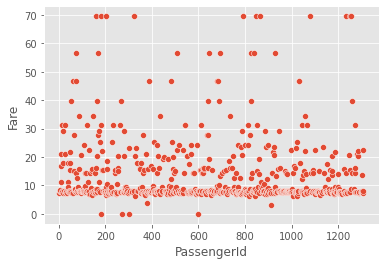

In [ ]:
pclass3 = all[all['Pclass']==3]
sns.scatterplot(x='PassengerId', y='Fare', data=pclass3)
pclass3['Fare'].describe()

けっこうばらついてますね。対象者のtikcet_countが1なのでそれでしぼってみる。

count    470.000000
mean       7.889955
std        1.031871
min        3.170800
25%        7.650000
50%        7.839600
75%        8.050000
max       19.966700
Name: Fare, dtype: float64

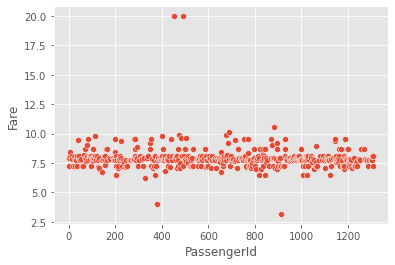

In [ ]:
pclass3Solo = pclass3[pclass3['ticket_count'] == 1]
sns.scatterplot(x='PassengerId', y='Fare', data=pclass3Solo)
pclass3Solo['Fare'].describe()

かなりきれいになった。10以上のものがほとんどなくなってる。複数でTicketを買ってるとFareは合計の金額になってると考えられる。（一人当たりの料金については別途考える。）外れ値があるので、median()で補完する。

In [ ]:
all.loc[all['PassengerId']==1044, 'Fare'] = pclass3Solo['Fare'].median()

## 3.2. Embarkedの補完

In [ ]:
all[all['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family_name,title,given_name,maiden_name,maiden_or_family,family_size,ticket_count,group_id,group_type,group_size
61,62.0,1.0,1.0,"Icard, Miss. Amelie",female,38.0,0.0,0.0,113572,80.0,B28,NaN,Icard,Miss,Amelie,NaN,Icard,1.0,2.0,113572,b,2
829,830.0,1.0,1.0,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0.0,0.0,113572,80.0,B28,NaN,Stone,Mrs,George Nelson (Martha Evelyn),Evelyn,Evelyn,1.0,2.0,113572,b,2


In [ ]:
pclass1 = all[all['Pclass']==1]
pclass1[['Embarked', 'PassengerId']].groupby('Embarked').count()

,PassengerId
Embarked,
C,141
Q,3
S,177


In [ ]:
pclass1_t6 = all[(all['Pclass']==1) & (all['Ticket'].str.len()==6)]
pclass1_t6[['Embarked', 'PassengerId']].groupby('Embarked').count()

,PassengerId
Embarked,
C,21
S,78


Sが多いのでここはSにしておく。

In [ ]:
all.loc[all['Embarked'].isnull(), 'Embarked'] = 'S'
all[all['Ticket']=='113572']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family_name,title,given_name,maiden_name,maiden_or_family,family_size,ticket_count,group_id,group_type,group_size
61,62.0,1.0,1.0,"Icard, Miss. Amelie",female,38.0,0.0,0.0,113572,80.0,B28,S,Icard,Miss,Amelie,NaN,Icard,1.0,2.0,113572,b,2
829,830.0,1.0,1.0,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0.0,0.0,113572,80.0,B28,S,Stone,Mrs,George Nelson (Martha Evelyn),Evelyn,Evelyn,1.0,2.0,113572,b,2


## 3.3 Ageの補完
titleを使って補完する。

In [ ]:
all['title'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Ms                2
Mlle              2
Major             2
Mme               1
Dona              1
Sir               1
Capt              1
the Countess      1
Don               1
Jonkheer          1
Lady              1
Name: title, dtype: int64

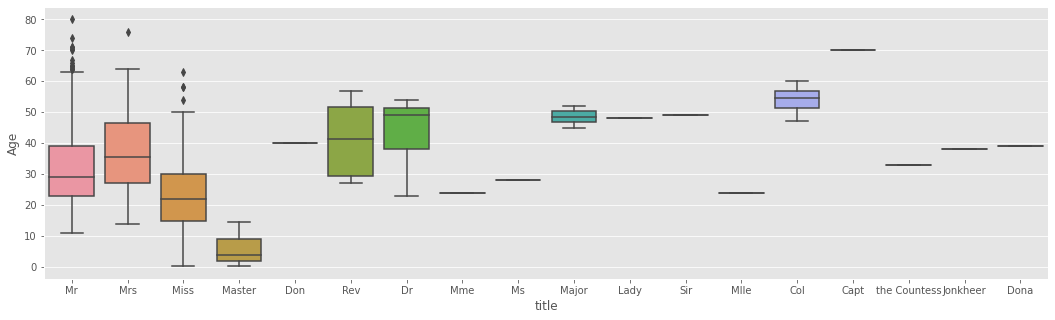

In [ ]:
plt.figure(figsize=(18, 5))
sns.boxplot(x='title', y='Age',data=all)

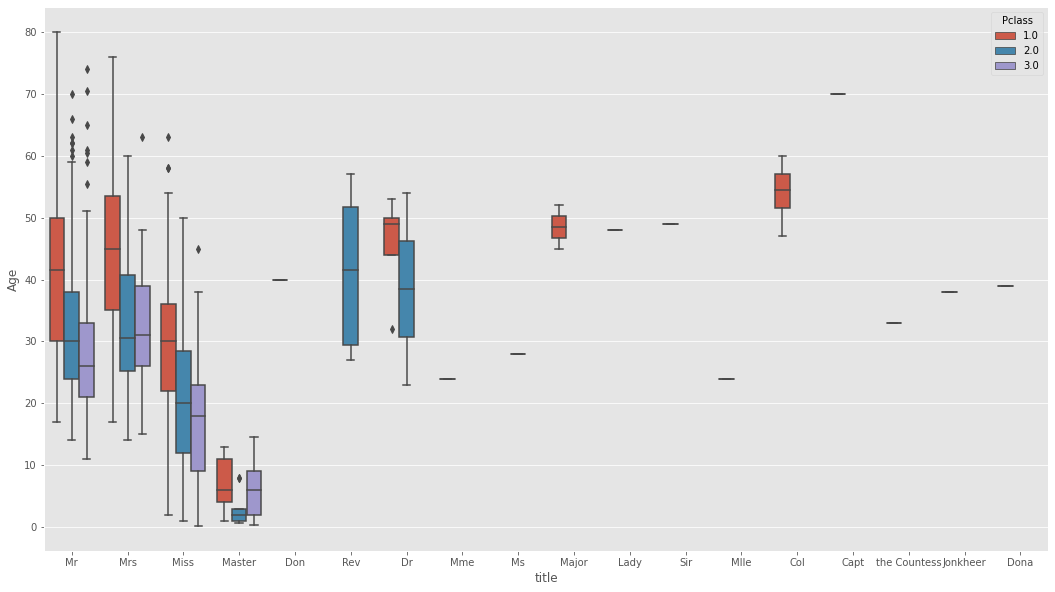

In [ ]:
plt.figure(figsize=(18, 10))
sns.boxplot(x='title', y='Age',hue='Pclass', data=all)

Pclassが違うと年齢の分布も違うように見える。

基本的には平均値で補完すればいいが、980はMsなので平均値が計算できない。

In [ ]:
all[(all['Age'].isnull()) & (all.title != 'Mr') & (all.title != 'Mrs') & (all.title != 'Miss') & (all.title != 'Master')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family_name,title,given_name,maiden_name,maiden_or_family,family_size,ticket_count,group_id,group_type,group_size
766,767.0,0.0,1.0,"Brewe, Dr. Arthur Jackson",male,NaN,0.0,0.0,112379,39.60,NaN,C,Brewe,Dr,Arthur Jackson,NaN,Brewe,1.0,1.0,112379,solo,1
979,980.0,NaN,3.0,"O'Donoghue, Ms. Bridget",female,NaN,0.0,0.0,364856,7.75,NaN,Q,O'Donoghue,Ms,Bridget,NaN,O'Donoghue,1.0,1.0,364856,solo,1


In [ ]:
all[['Pclass', 'title', 'Age']].groupby(['Pclass', 'title']).mean()

Age
Pclass title                  
1.0    Capt          70.000000
       Col           54.000000
       Don           40.000000
       Dona          39.000000
       Dr            45.600000
       Jonkheer      38.000000
       Lady          48.000000
       Major         48.500000
       Master         6.984000
       Miss          30.338983
       Mlle          24.000000
       Mme           24.000000
       Mr            41.450758
       Mrs           43.208955
       Sir           49.000000
       the Countess  33.000000
2.0    Dr            38.500000
       Master         2.757273
       Miss          20.717083
       Mr            32.346715
       Mrs           33.518519
       Ms            28.000000
       Rev           41.250000
3.0    Master         6.090000
       Miss          17.360874
       Mr            28.318910
       Mrs           32.326531
       Ms                  NaN

In [ ]:
all[(all['title']=='Miss') & (all['Pclass']==3)]['Age'].quantile([0.5, 0.75, 0.9])

0.50    18.0
0.75    23.0
0.90    29.8
Name: Age, dtype: float64

In [ ]:
all[(all['title']=='Miss') & (all['Age']<1)]['Age'].describe()

count    4.000000
mean     0.647500
std      0.328266
min      0.170000
25%      0.605000
50%      0.750000
75%      0.792500
max      0.920000
Name: Age, dtype: float64

In [ ]:
all['title_age'] = all.groupby(['title'])['Age'].transform('mean')
all.loc[(all['Age'].isnull()) & ( (all.title=='Dr') | (all.title=='Ms')), 'Age'] = all['title_age']

In [ ]:
all['title_age'] = all.groupby(['Pclass', 'title'])['Age'].transform('mean')
all.loc[(all['Age'].isnull()), 'Age'] = all['title_age']

all = all.drop(['title_age'], axis=1)
all[all['Age'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family_name,title,given_name,maiden_name,maiden_or_family,family_size,ticket_count,group_id,group_type,group_size


# 4. Feature Engineering

## 4.1. 一人当たりの料金

同じTicketを使って乗ってる場合、Fareは全員分の料金のように見える。一人当たりの料金を表す属性を追加する。

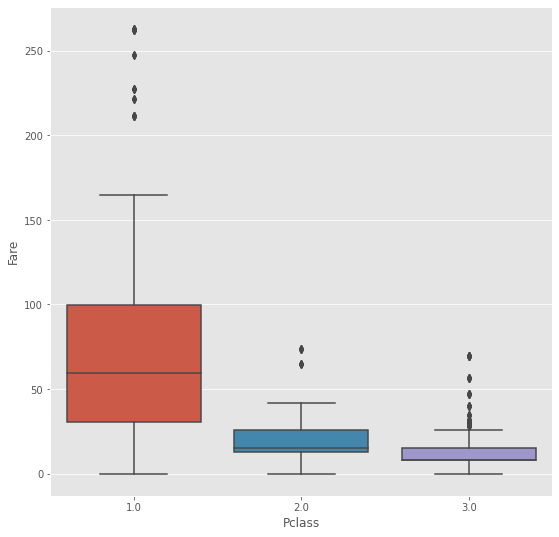

In [ ]:
lt_500 = all[all['Fare']< 500]
plt.figure(figsize=(9, 9))
sns.boxplot(x='Pclass', y='Fare', data=lt_500)

In [ ]:
all['price'] = all['Fare'] / all['ticket_count']

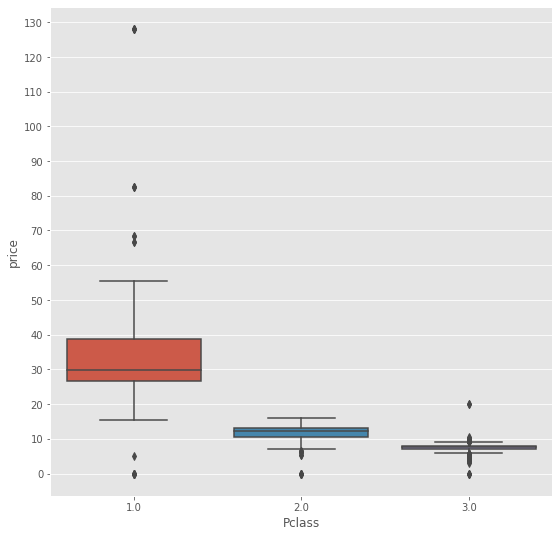

In [ ]:
import matplotlib.ticker as ticker
plt.figure(figsize=(9, 9))
sns.boxplot(x='Pclass', y='price', data=all)
ax = plt.gca()
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))

Pclass3でPclass2より高いのがいるので見てみましょう。

In [ ]:
all[(all['price']>19) & (all['Pclass']==3)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family_name,title,given_name,maiden_name,maiden_or_family,family_size,ticket_count,group_id,group_type,group_size,price
451,452.0,0.0,3.0,"Hagland, Mr. Ingvald Olai Olsen",male,28.31891,1.0,0.0,65303,19.9667,NaN,S,Hagland,Mr,Ingvald Olai Olsen,NaN,Hagland,2.0,1.0,65303,c,2,19.9667
490,491.0,0.0,3.0,"Hagland, Mr. Konrad Mathias Reiersen",male,28.31891,1.0,0.0,65304,19.9667,NaN,S,Hagland,Mr,Konrad Mathias Reiersen,NaN,Hagland,2.0,1.0,65303,c,2,19.9667


特に変なところはない

## 4.2. お世話する人される人

グループ内の助ける側の人や助けられる側の人を特徴量に追加する前にまずそれぞれの人が助ける側か助けられる側かを表す属性を追加する。

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


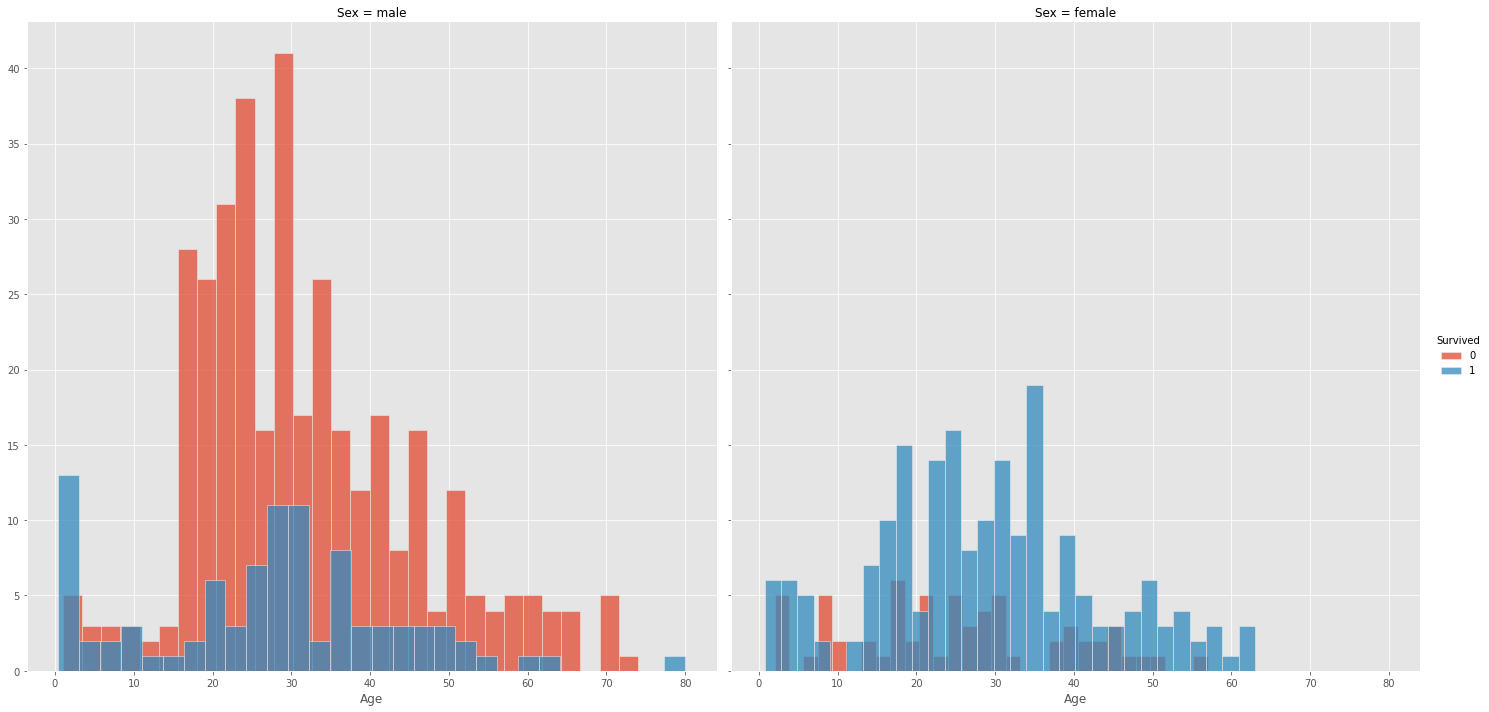

In [ ]:
g = sns.FacetGrid(train, col='Sex', hue='Survived', size=10)
g.map(sns.histplot, 'Age', bins=30)
g.add_legend()

In [ ]:
helpers = train[(train['Sex']=='male') & (train['Age']>=16) &(train['Age']<17)]                                              
survived(helpers)

,PassengerId,rate
Survived,,
0,10,0.909091
1,1,0.090909


16歳から急に死ぬ人が増えてるので、16歳以上の男を助ける側とする。

In [ ]:
all.loc[((all['Sex']=='male') & (all['Age']>=16)), 'is_helper'] = 1
all['is_helper'].fillna(0, inplace=True)
all['is_helper'] = all['is_helper'].astype(int)
all

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family_name,title,given_name,maiden_name,maiden_or_family,family_size,ticket_count,group_id,group_type,group_size,price,is_helper
0,1.0,0.0,3.0,"Braund, Mr. Owen Harris",male,22.00000,1.0,0.0,A/5 21171,7.2500,NaN,S,Braund,Mr,Owen Harris,NaN,Braund,2.0,1.0,A/5 21171,c,2,7.250000,1
1,2.0,1.0,1.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00000,1.0,0.0,PC 17599,71.2833,C85,C,Cumings,Mrs,John Bradley (Florence Briggs Thayer),Thayer,Thayer,2.0,2.0,PC 17599,a,2,35.641650,0
2,3.0,1.0,3.0,"Heikkinen, Miss. Laina",female,26.00000,0.0,0.0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,Miss,Laina,NaN,Heikkinen,1.0,1.0,STON/O2. 3101282,solo,1,7.925000,0
3,4.0,1.0,1.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00000,1.0,0.0,113803,53.1000,C123,S,Futrelle,Mrs,Jacques Heath (Lily May Peel),Peel,Peel,2.0,2.0,113803,a,2,26.550000,0
4,5.0,0.0,3.0,"Allen, Mr. William Henry",male,35.00000,0.0,0.0,373450,8.0500,NaN,S,Allen,Mr,William Henry,NaN,Allen,1.0,1.0,373450,solo,1,8.050000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305.0,NaN,3.0,"Spector, Mr. Woolf",male,28.31891,0.0,0.0,A.5. 3236,8.0500,NaN,S,Spector,Mr,Woolf,NaN,Spector,1.0,1.0,A.5. 3236,solo,1,8.050000,1
1305,1306.0,NaN,1.0,"Oliva y Ocana, Dona. Fermina",female,39.00000,0.0,0.0,PC 17758,108.9000,C105,C,Oliva y Ocana,Dona,Fermina,NaN,Oliva y Ocana,1.0,3.0,PC 17758,b,3,36.300000,0
1306,1307.0,NaN,3.0,"Saether, Mr. Simon Sivertsen",male,38.50000,0.0,0.0,SOTON/O.Q. 3101262,7.2500,NaN,S,Saether,Mr,Simon Sivertsen,NaN,Saether,1.0,1.0,SOTON/O.Q. 3101262,solo,1,7.250000,1
1307,1308.0,NaN,3.0,"Ware, Mr. Frederick",male,28.31891,0.0,0.0,359309,8.0500,NaN,S,Ware,Mr,Frederick,NaN,Ware,1.0,1.0,359309,solo,1,8.050000,1


## 4.3. 無料で乗ってる人

In [ ]:
price_0 = all[all['price']==0.0]
survived(price_0)

,PassengerId,rate
Survived,,
0.0,14,0.933333
1.0,1,0.066667


ほとんで死んでる。titleはMr かJonkeer （貴族の称号）

price==0の人をみてみる。

In [ ]:
price_0

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family_name,title,given_name,maiden_name,maiden_or_family,family_size,ticket_count,group_id,group_type,group_size,price,is_helper
179,180.0,0.0,3.0,"Leonard, Mr. Lionel",male,36.000000,0.0,0.0,LINE,0.0,NaN,S,Leonard,Mr,Lionel,NaN,Leonard,1.0,4.0,LINE,b,4,0.0,1
263,264.0,0.0,1.0,"Harrison, Mr. William",male,40.000000,0.0,0.0,112059,0.0,B94,S,Harrison,Mr,William,NaN,Harrison,1.0,1.0,112059,solo,1,0.0,1
271,272.0,1.0,3.0,"Tornquist, Mr. William Henry",male,25.000000,0.0,0.0,LINE,0.0,NaN,S,Tornquist,Mr,William Henry,NaN,Tornquist,1.0,4.0,LINE,b,4,0.0,1
277,278.0,0.0,2.0,"Parkes, Mr. Francis ""Frank""",male,32.346715,0.0,0.0,239853,0.0,NaN,S,Parkes,Mr,"Francis ""Frank""",NaN,Parkes,1.0,3.0,239853,b,3,0.0,1
302,303.0,0.0,3.0,"Johnson, Mr. William Cahoone Jr",male,19.000000,0.0,0.0,LINE,0.0,NaN,S,Johnson,Mr,William Cahoone Jr,NaN,Johnson,1.0,4.0,LINE,b,4,0.0,1
413,414.0,0.0,2.0,"Cunningham, Mr. Alfred Fleming",male,32.346715,0.0,0.0,239853,0.0,NaN,S,Cunningham,Mr,Alfred Fleming,NaN,Cunningham,1.0,3.0,239853,b,3,0.0,1
466,467.0,0.0,2.0,"Campbell, Mr. William",male,32.346715,0.0,0.0,239853,0.0,NaN,S,Campbell,Mr,William,NaN,Campbell,1.0,3.0,239853,b,3,0.0,1
481,482.0,0.0,2.0,"Frost, Mr. Anthony Wood ""Archie""",male,32.346715,0.0,0.0,239854,0.0,NaN,S,Frost,Mr,"Anthony Wood ""Archie""",NaN,Frost,1.0,1.0,239854,solo,1,0.0,1
597,598.0,0.0,3.0,"Johnson, Mr. Alfred",male,49.000000,0.0,0.0,LINE,0.0,NaN,S,Johnson,Mr,Alfred,NaN,Johnson,1.0,4.0,LINE,b,4,0.0,1
633,634.0,0.0,1.0,"Parr, Mr. William Henry Marsh",male,41.450758,0.0,0.0,112052,0.0,NaN,S,Parr,Mr,William Henry Marsh,NaN,Parr,1.0,1.0,112052,solo,1,0.0,1


次に０じゃないけどほぼ０の客を探す

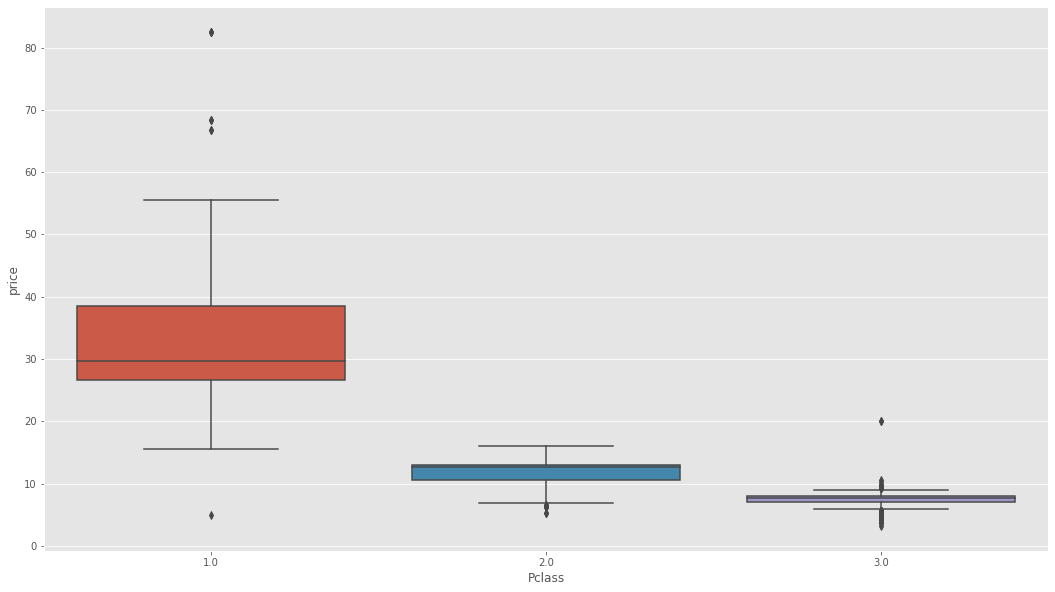

In [ ]:
plt.figure(figsize=(18, 10))
all_x = all[(all['price']>0) & (all['price']<120)]
sns.boxplot(x='Pclass', y='price',data=all_x)

In [ ]:
pclass1 = all[all.Pclass==1]
pclass1[(pclass1['price']>0) &(pclass1['price']<6)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family_name,title,given_name,maiden_name,maiden_or_family,family_size,ticket_count,group_id,group_type,group_size,price,is_helper
872,873.0,0.0,1.0,"Carlsson, Mr. Frans Olof",male,33.0,0.0,0.0,695,5.0,B51 B53 B55,S,Carlsson,Mr,Frans Olof,NaN,Carlsson,1.0,1.0,695,solo,1,5.0,1


873は5$はらってるけど、安すぎる、男、大人なので無料客とみなす。

In [ ]:
pclass2 = all[all['Pclass']==2]
pclass2[(pclass2['price']>0) & (pclass2['price'] < 7)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family_name,title,given_name,maiden_name,maiden_or_family,family_size,ticket_count,group_id,group_type,group_size,price,is_helper
58,59.0,1.0,2.0,"West, Miss. Constance Mirium",female,5.00,1.0,2.0,C.A. 34651,27.75,NaN,S,West,Miss,Constance Mirium,NaN,West,4.0,4.0,C.A. 34651,a,4,6.9375,0
407,408.0,1.0,2.0,"Richards, Master. William Rowe",male,3.00,1.0,1.0,29106,18.75,NaN,S,Richards,Master,William Rowe,NaN,Richards,3.0,3.0,29106,a,3,6.2500,0
437,438.0,1.0,2.0,"Richards, Mrs. Sidney (Emily Hocking)",female,24.00,2.0,3.0,29106,18.75,NaN,S,Richards,Mrs,Sidney (Emily Hocking),Hocking,Hocking,6.0,3.0,29106,c,3,6.2500,0
450,451.0,0.0,2.0,"West, Mr. Edwy Arthur",male,36.00,1.0,2.0,C.A. 34651,27.75,NaN,S,West,Mr,Edwy Arthur,NaN,West,4.0,4.0,C.A. 34651,a,4,6.9375,1
472,473.0,1.0,2.0,"West, Mrs. Edwy Arthur (Ada Mary Worth)",female,33.00,1.0,2.0,C.A. 34651,27.75,NaN,S,West,Mrs,Edwy Arthur (Ada Mary Worth),Worth,Worth,4.0,4.0,C.A. 34651,a,4,6.9375,0
714,715.0,0.0,2.0,"Greenberg, Mr. Samuel",male,52.00,0.0,0.0,250647,13.00,NaN,S,Greenberg,Mr,Samuel,NaN,Greenberg,1.0,2.0,250647,b,2,6.5000,1
772,773.0,0.0,2.0,"Mack, Mrs. (Mary)",female,57.00,0.0,0.0,S.O./P.P. 3,10.50,E77,S,Mack,Mrs,(Mary),Mary,Mary,1.0,2.0,S.O./P.P. 3,b,2,5.2500,0
800,801.0,0.0,2.0,"Ponesell, Mr. Martin",male,34.00,0.0,0.0,250647,13.00,NaN,S,Ponesell,Mr,Martin,NaN,Ponesell,1.0,2.0,250647,b,2,6.5000,1
831,832.0,1.0,2.0,"Richards, Master. George Sibley",male,0.83,1.0,1.0,29106,18.75,NaN,S,Richards,Master,George Sibley,NaN,Richards,3.0,3.0,29106,a,3,6.2500,0
841,842.0,0.0,2.0,"Mudd, Mr. Thomas Charles",male,16.00,0.0,0.0,S.O./P.P. 3,10.50,NaN,S,Mudd,Mr,Thomas Charles,NaN,Mudd,1.0,2.0,S.O./P.P. 3,b,2,5.2500,1


773と842は親戚かなんかかな。他の無料客は全部男、Ticketが全然違う、金額が飛び抜けて安いやけじゃない、ということでこれは無料客とは見なさない。

In [ ]:
pclass3 = all[all['Pclass']==3]
pclass3[(pclass3['price']>0) & (pclass3['price'] < 4)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family_name,title,given_name,maiden_name,maiden_or_family,family_size,ticket_count,group_id,group_type,group_size,price,is_helper
8,9.0,1.0,3.0,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0.0,2.0,347742,11.1333,NaN,S,Johnson,Mrs,Oscar W (Elisabeth Vilhelmina Berg),Berg,Berg,3.0,3.0,347742,a,3,3.7111,0
172,173.0,1.0,3.0,"Johnson, Miss. Eleanor Ileen",female,1.0,1.0,1.0,347742,11.1333,NaN,S,Johnson,Miss,Eleanor Ileen,NaN,Johnson,3.0,3.0,347742,a,3,3.7111,0
869,870.0,1.0,3.0,"Johnson, Master. Harold Theodor",male,4.0,1.0,1.0,347742,11.1333,NaN,S,Johnson,Master,Harold Theodor,NaN,Johnson,3.0,3.0,347742,a,3,3.7111,0
912,913.0,NaN,3.0,"Olsen, Master. Artur Karl",male,9.0,0.0,1.0,C 17368,3.1708,NaN,S,Olsen,Master,Artur Karl,NaN,Olsen,2.0,1.0,4579,c,2,3.1708,0


913は子供（他の無料客は全部成人男性）なので違う。

In [ ]:
all.loc[(all['price']==0), 'free_ticket'] = 1
all.loc[(all['PassengerId']==873), 'free_ticket'] = 1
all['free_ticket'].fillna(0, inplace=True)
all['free_ticket'] = all['free_ticket'].astype(int)



## 4.4. Cabin

### Cabinがnullかどうか

In [ ]:
cabin_null = all[all['Cabin'].isnull()]
survived(cabin_null)

,PassengerId,rate
Survived,,
0.0,481,0.700146
1.0,206,0.299854


In [ ]:
cabin_exist = train[train['Cabin'].isnull() == False]
survived(cabin_exist)

,PassengerId,rate
Survived,,
0,68,0.333333
1,136,0.666667


In [ ]:
all['null_cabin'] = all['Cabin'].isnull() * 1

### Cabin自体

In [ ]:
all['Cabin'].value_counts()

C23 C25 C27        6
G6                 5
B57 B59 B63 B66    5
F2                 4
F4                 4
                  ..
A7                 1
A9                 1
A32                1
C99                1
C28                1
Name: Cabin, Length: 186, dtype: int64

In [ ]:
all['cabin2'] = all['Cabin'].fillna('Z')
all['cabin_ini'] = all['cabin2'].str[:1]

## 4.5. グループ内の助ける人、助けられる人

In [ ]:
all['is_s_helper'] = all['is_helper'] * all['Survived']
all['is_s_helper'].fillna(0, inplace=True)
all['is_s_helper'] = all['is_s_helper'].astype(int)

In [ ]:
all['is_d_helper'] = all['is_helper'] * (1 - all['Survived'])
all['is_d_helper'].fillna(0, inplace=True)
all['is_d_helper'] = all['is_d_helper'].astype(int)

In [ ]:
all['is_u_helper'] = all['is_helper'] * all['Survived'].isnull()
all['is_u_helper'].fillna(0, inplace=True)
all['is_u_helper'] = all['is_u_helper'].astype(int)

In [ ]:
all['g_s_helpers'] = all.groupby('group_id')['is_s_helper'].transform('sum')
all['g_d_helpers'] = all.groupby('group_id')['is_d_helper'].transform('sum')
all['g_u_helpers'] = all.groupby('group_id')['is_u_helper'].transform('sum')

このままでは、自分自身の情報がg_x_helpersに入ってしまう。これは、だめなので自分の分をg_x_helpersから取り除くようにする。

In [ ]:
all.loc[(all.is_s_helper==1), 'g_s_helpers'] = all['g_s_helpers'] - 1
all.loc[(all.is_d_helper==1), 'g_d_helpers'] = all['g_d_helpers'] - 1
all.loc[(all.is_u_helper==1), 'g_u_helpers'] = all['g_u_helpers'] - 1

助けられる側の方の情報も追加すべき。g_s_helpeeとか。

In [ ]:
all['is_s_helpee'] = (1 - all['is_helper']) * all['Survived']
all['is_s_helpee'].fillna(0, inplace=True)
all['is_s_helpee'] = all['is_s_helpee'].astype(int)

all['is_d_helpee'] = (1 - all['is_helper']) * (1 - all['Survived'])
all['is_d_helpee'].fillna(0, inplace=True)
all['is_d_helpee'] = all['is_d_helpee'].astype(int)

all['is_u_helpee'] = (1 - all['is_helper']) * all['Survived'].isnull()
all['is_u_helpee'].fillna(0, inplace=True)
all['is_u_helpee'] = all['is_u_helpee'].astype(int)

In [ ]:
all['g_s_helpees'] = all.groupby('group_id')['is_s_helpee'].transform('sum')
all['g_d_helpees'] = all.groupby('group_id')['is_d_helpee'].transform('sum')
all['g_u_helpees'] = all.groupby('group_id')['is_u_helpee'].transform('sum')

In [ ]:
all.loc[(all.is_s_helpee==1), 'g_s_helpees'] = all['g_s_helpees'] - 1
all.loc[(all.is_d_helpee==1), 'g_d_helpees'] = all['g_d_helpees'] - 1
all.loc[(all.is_u_helpee==1), 'g_u_helpees'] = all['g_u_helpees'] - 1

In [ ]:
all = all.drop(['is_s_helper', 'is_d_helper', 'is_u_helper', 'is_s_helpee', 'is_d_helpee', 'is_u_helpee'], axis=1)

## 4.6. 社会的身分
titleは貴族とか医者など、社会的身分や職業を表していることがある。これらも生存率に影響してくると考えられる。
Noble 男: Jonkheer, Sir, Don
Noble 女: Dona, Countess, Lady

聖職者: Rev
軍人: Col, Capt, Major
Mlle = Miss
Mme = Mrs



In [ ]:
all['title'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Mlle              2
Major             2
Ms                2
Dona              1
the Countess      1
Mme               1
Jonkheer          1
Lady              1
Don               1
Capt              1
Sir               1
Name: title, dtype: int64

In [ ]:
all['title'] = all['title'].replace(['Mlle', 'Ms'], 'Miss')
all['title'] = all['title'].replace('Mme', 'Mrs')
all['title'] = all['title'].replace(['Col', 'Major', 'Capt'], 'Army')
all['title'] = all['title'].replace(['Jonkheer', 'Sir', 'Don', 'Dona', 'the Countess', 'Lady'], 'Noble')

all['title'].value_counts()



Mr        757
Miss      264
Mrs       198
Master     61
Dr          8
Rev         8
Army        7
Noble       6
Name: title, dtype: int64

# 5. きれいにする

In [ ]:
all.dtypes

PassengerId         float64
Survived            float64
Pclass              float64
Name                 object
Sex                  object
Age                 float64
SibSp               float64
Parch               float64
Ticket               object
Fare                float64
Cabin                object
Embarked             object
family_name          object
title                object
given_name           object
maiden_name          object
maiden_or_family     object
family_size         float64
ticket_count        float64
group_id             object
group_type           object
group_size            int64
price               float64
is_helper             int64
free_ticket           int64
null_cabin            int64
cabin2               object
cabin_ini            object
g_s_helpers           int64
g_d_helpers           int64
g_u_helpers           int64
g_s_helpees           int64
g_d_helpees           int64
g_u_helpees           int64
dtype: object

In [ ]:
all2 = all.drop(['PassengerId', 'Name', 'Ticket', 'Fare', 'Cabin', 'family_name', 'given_name', 'maiden_name', 'maiden_or_family', 'group_id', 'group_type', 'SibSp', 'Parch', 'family_size', 'ticket_count', 'cabin2', 'cabin_ini'], axis=1)

In [ ]:
all2['Pclass'] = all2['Pclass'].astype(int)
all2['price'] = all2['price'].round().astype(int)

In [ ]:
all2.isnull().sum()

Survived       418
Pclass           0
Sex              0
Age              0
Embarked         0
title            0
group_size       0
price            0
is_helper        0
free_ticket      0
null_cabin       0
g_s_helpers      0
g_d_helpers      0
g_u_helpers      0
g_s_helpees      0
g_d_helpees      0
g_u_helpees      0
dtype: int64

In [ ]:
cats = all2.columns[all2.dtypes=='object']
cats

Index(['Sex', 'Embarked', 'title'], dtype='object')

In [ ]:
from sklearn.preprocessing import LabelEncoder
for c in cats:
  le = LabelEncoder()
  le = le.fit(all2[c])
  all2[c] = le.transform(all2[c])


In [ ]:
train2 = all2[all2['Survived'].notnull()].reset_index(drop=True)
train2.corr()

,Survived,Pclass,Sex,Age,Embarked,title,group_size,price,is_helper,free_ticket,null_cabin,g_s_helpers,g_d_helpers,g_u_helpers,g_s_helpees,g_d_helpees,g_u_helpees
Survived,1.000000,-0.338481,-0.543351,-0.072144,-0.167675,-0.076721,0.055834,0.288685,-0.558221,-0.089351,-0.316912,0.119663,0.012791,0.034372,0.296298,-0.198698,0.083455
Pclass,-0.338481,1.000000,0.131900,-0.406932,0.162098,-0.051554,-0.032051,-0.762414,0.086282,-0.070176,0.725541,-0.017494,-0.006405,-0.077998,-0.306894,0.207448,-0.066889
Sex,-0.543351,0.131900,1.000000,0.117265,0.108262,0.012082,-0.176394,-0.115063,0.900117,0.099755,0.140391,0.006348,-0.101949,-0.089856,-0.168213,-0.065486,-0.128869
Age,-0.072144,-0.406932,0.117265,1.000000,-0.015427,0.376719,-0.243629,0.345069,0.292575,0.053243,-0.269551,0.011493,-0.112636,-0.037159,-0.068605,-0.247189,-0.168140
Embarked,-0.167675,0.162098,0.108262,-0.015427,1.000000,0.019001,0.019157,-0.275943,0.098562,0.079235,0.160196,-0.017374,0.082126,-0.007423,-0.116911,0.098774,-0.048300
title,-0.076721,-0.051554,0.012082,0.376719,0.019001,1.000000,-0.164633,0.020996,0.204297,0.046370,0.006813,0.043744,-0.010780,0.025851,-0.080071,-0.184533,-0.174370
group_size,0.055834,-0.032051,-0.176394,-0.243629,0.019157,-0.164633,1.000000,0.048929,-0.322037,0.002971,-0.050375,0.300375,0.575520,0.515176,0.331407,0.665385,0.619413
price,0.288685,-0.762414,-0.115063,0.345069,-0.275943,0.020996,0.048929,1.000000,-0.060148,-0.141889,-0.643600,0.096902,-0.031975,0.043396,0.266475,-0.173635,0.105863
is_helper,-0.558221,0.086282,0.900117,0.292575,0.098562,0.204297,-0.322037,-0.060148,1.000000,0.110824,0.120051,0.011388,-0.130817,-0.124556,-0.221714,-0.223201,-0.228535
free_ticket,-0.089351,-0.070176,0.099755,0.053243,0.079235,0.046370,0.002971,-0.141889,0.110824,1.000000,-0.006773,0.038349,0.176775,-0.021405,-0.061131,-0.037403,-0.055481


In [ ]:
train_X = train2.drop(['Survived'], axis=1)
train_Y = train2['Survived']

In [ ]:
test_X = all2[all2['Survived'].isnull()].drop(['Survived'],axis=1).reset_index(drop=True)

# 6. モデル

In [ ]:
cat_feature = ['Pclass', 'Sex', 'Embarked', 'title', 'is_helper', 'free_ticket', 'null_cabin']
for f in cat_feature:
  train_X[f] = train_X[f].astype('category')
  test_X[f] = test_X[f].astype('category')

## 6.1. パラメータ最適化

In [ ]:
!pip install optuna
#import lightgbm as lgb
import optuna.integration.lightgbm as olgb
from sklearn.model_selection import train_test_split

lgbm_params = {
    "objective": "binary",
    "randome_seed": 1234
}

X_train, X_val, y_train, y_val = train_test_split(train_X, train_Y, test_size=0.2, random_state=1234, shuffle=True, stratify=None)
lgb_train = olgb.Dataset(X_train, y_train)
lgb_eval = olgb.Dataset(X_val, y_val, reference=lgb_train)

opt = olgb.train(
    lgbm_params,
    lgb_train,
    valid_sets=lgb_eval,
    num_boost_round=100,
    early_stopping_rounds=10,
    verbose_eval=10)


[I 2021-04-11 05:57:29,137] A new study created in memory with name: no-name-daba6ce5-0911-4f2c-ac48-cc5e1c47e883
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

feature_fraction, val_score: 0.353954:  29%|##8       | 2/7 [00:00<00:00,  9.82it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.426054
[20]	valid_0's binary_logloss: 0.371122
[30]	valid_0's binary_logloss: 0.359119
Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.358532
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.417474
[20]	valid_0's binary_logloss: 0.365187
[30]	valid_0's binary_logloss: 0.35407
Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.353954


feature_fraction, val_score: 0.353954:  57%|#####7    | 4/7 [00:00<00:00,  9.82it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.414405
[20]	valid_0's binary_logloss: 0.366539
[30]	valid_0's binary_logloss: 0.360586
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.359423
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.436008
[20]	valid_0's binary_logloss: 0.373658
[30]	valid_0's binary_logloss: 0.359027
[40]	valid_0's binary_logloss: 0.364648
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.359027


feature_fraction, val_score: 0.351719:  86%|########5 | 6/7 [00:00<00:00,  8.69it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.415929
[20]	valid_0's binary_logloss: 0.368514
[30]	valid_0's binary_logloss: 0.366142
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.361443
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.484751
[20]	valid_0's binary_logloss: 0.381399
[30]	valid_0's binary_logloss: 0.358651
[40]	valid_0's binary_logloss: 0.355203
[50]	valid_0's binary_logloss: 0.35337
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.351719


num_leaves, val_score: 0.345529:   5%|5         | 1/20 [00:00<00:01, 10.63it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.451337
[20]	valid_0's binary_logloss: 0.373556
[30]	valid_0's binary_logloss: 0.354043
[40]	valid_0's binary_logloss: 0.353269
[50]	valid_0's binary_logloss: 0.350921
Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.350201
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.473985
[20]	valid_0's binary_logloss: 0.391403
[30]	valid_0's binary_logloss: 0.370054
[40]	valid_0's binary_logloss: 0.357812
[50]	valid_0's binary_logloss: 0.35269
[60]	valid_0's binary_logloss: 0.352825
[70]	valid_0's binary_logloss: 0.350696
[80]	valid_0's binary_logloss: 0.34873
[90]	valid_0's binary_logloss: 0.347116
Early stopping, best iteration is:
[87]	valid_0's binary_logloss: 0.345529


num_leaves, val_score: 0.345529:  15%|#5        | 3/20 [00:00<00:01,  9.44it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.451337
[20]	valid_0's binary_logloss: 0.373556
[30]	valid_0's binary_logloss: 0.354043
[40]	valid_0's binary_logloss: 0.353269
[50]	valid_0's binary_logloss: 0.350921
Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.350201
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.451337
[20]	valid_0's binary_logloss: 0.373556
[30]	valid_0's binary_logloss: 0.354043
[40]	valid_0's binary_logloss: 0.353269
[50]	valid_0's binary_logloss: 0.350921
Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.350201


num_leaves, val_score: 0.345529:  25%|##5       | 5/20 [00:00<00:01,  8.87it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.451337
[20]	valid_0's binary_logloss: 0.373556
[30]	valid_0's binary_logloss: 0.354043
[40]	valid_0's binary_logloss: 0.353269
[50]	valid_0's binary_logloss: 0.350921
Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.350201
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.451337
[20]	valid_0's binary_logloss: 0.373556
[30]	valid_0's binary_logloss: 0.354043
[40]	valid_0's binary_logloss: 0.353269
[50]	valid_0's binary_logloss: 0.350921
Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.350201


num_leaves, val_score: 0.345529:  35%|###5      | 7/20 [00:00<00:01,  8.23it/s][I 2021-04-11 05:57:30,766] Trial 13 finished with value: 0.35020147829057147 and parameters: {'num_leaves': 69}. Best is trial 7 with value: 0.3455291045505146.


Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.451337
[20]	valid_0's binary_logloss: 0.373556
[30]	valid_0's binary_logloss: 0.354043
[40]	valid_0's binary_logloss: 0.353269
[50]	valid_0's binary_logloss: 0.350921
Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.350201
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.451337
[20]	valid_0's binary_logloss: 0.373556
[30]	valid_0's binary_logloss: 0.354043
[40]	valid_0's binary_logloss: 0.353269
[50]	valid_0's binary_logloss: 0.350921
Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.350201


num_leaves, val_score: 0.345529:  45%|####5     | 9/20 [00:01<00:01,  7.82it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.451337
[20]	valid_0's binary_logloss: 0.373556
[30]	valid_0's binary_logloss: 0.354043
[40]	valid_0's binary_logloss: 0.353269
[50]	valid_0's binary_logloss: 0.350921
Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.350201
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.451337
[20]	valid_0's binary_logloss: 0.373556
[30]	valid_0's binary_logloss: 0.354043
[40]	valid_0's binary_logloss: 0.353269
[50]	valid_0's binary_logloss: 0.350921
Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.350201


[I 2021-04-11 05:57:31,036] Trial 15 finished with value: 0.35020147829057147 and parameters: {'num_leaves': 216}. Best is trial 7 with value: 0.3455291045505146.
num_leaves, val_score: 0.345529:  55%|#####5    | 11/20 [00:01<00:01,  8.10it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.451337
[20]	valid_0's binary_logloss: 0.373556
[30]	valid_0's binary_logloss: 0.354043
[40]	valid_0's binary_logloss: 0.353269
[50]	valid_0's binary_logloss: 0.350921
Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.350201
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.473985
[20]	valid_0's binary_logloss: 0.391403
[30]	valid_0's binary_logloss: 0.370054
[40]	valid_0's binary_logloss: 0.357812
[50]	valid_0's binary_logloss: 0.35269
[60]	valid_0's binary_logloss: 0.352825
[70]	valid_0's binary_logloss: 0.350696
[80]	valid_0's binary_logloss: 0.34873
[90]	valid_0's binary_logloss: 0.347116
Early stopping, best iteration is:
[87]	valid_0's binary_logloss: 0.345529
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.467888
[20]	valid_0's binary_logloss: 0.384367
[30]	valid_0's binary_logl

num_leaves, val_score: 0.345529:  65%|######5   | 13/20 [00:01<00:00,  9.06it/s]

[40]	valid_0's binary_logloss: 0.354583
[50]	valid_0's binary_logloss: 0.349507
[60]	valid_0's binary_logloss: 0.350765
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.349507
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.485296
[20]	valid_0's binary_logloss: 0.407225
[30]	valid_0's binary_logloss: 0.382619
[40]	valid_0's binary_logloss: 0.366264
[50]	valid_0's binary_logloss: 0.358675
[60]	valid_0's binary_logloss: 0.356171
[70]	valid_0's binary_logloss: 0.353594
[80]	valid_0's binary_logloss: 0.351692
[90]	valid_0's binary_logloss: 0.350452
[100]	valid_0's binary_logloss: 0.349402
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.349071
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.451337
[20]	valid_0's binary_logloss: 0.373556
[30]	valid_0's binary_logloss: 0.354043
[40]	valid_0's binary_logloss: 0.353269
[50]	valid_0's binary_logloss: 0

num_leaves, val_score: 0.345529:  80%|########  | 16/20 [00:01<00:00,  8.90it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.451337
[20]	valid_0's binary_logloss: 0.373556
[30]	valid_0's binary_logloss: 0.354043
[40]	valid_0's binary_logloss: 0.353269
[50]	valid_0's binary_logloss: 0.350921
Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.350201
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.451337
[20]	valid_0's binary_logloss: 0.373556
[30]	valid_0's binary_logloss: 0.354043
[40]	valid_0's binary_logloss: 0.353269
[50]	valid_0's binary_logloss: 0.350921
Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.350201


num_leaves, val_score: 0.345529:  90%|######### | 18/20 [00:02<00:00,  8.40it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.451708
[20]	valid_0's binary_logloss: 0.374359
[30]	valid_0's binary_logloss: 0.354959
[40]	valid_0's binary_logloss: 0.354417
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.351738
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.451337
[20]	valid_0's binary_logloss: 0.373556
[30]	valid_0's binary_logloss: 0.354043
[40]	valid_0's binary_logloss: 0.353269
[50]	valid_0's binary_logloss: 0.350921
Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.350201


bagging, val_score: 0.345529:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.485296
[20]	valid_0's binary_logloss: 0.407225
[30]	valid_0's binary_logloss: 0.382619
[40]	valid_0's binary_logloss: 0.366264
[50]	valid_0's binary_logloss: 0.358675
[60]	valid_0's binary_logloss: 0.356171
[70]	valid_0's binary_logloss: 0.353594
[80]	valid_0's binary_logloss: 0.351692
[90]	valid_0's binary_logloss: 0.350452
[100]	valid_0's binary_logloss: 0.349402
Did not meet early stopping. Best iteration is:
[99]	valid_0's binary_logloss: 0.349071
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.451337
[20]	valid_0's binary_logloss: 0.373556
[30]	valid_0's binary_logloss: 0.354043
[40]	valid_0's binary_logloss: 0.353269
[50]	valid_0's binary_logloss: 0.350921
Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.350201


bagging, val_score: 0.344762:  20%|##        | 2/10 [00:00<00:00, 14.21it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.477755
[20]	valid_0's binary_logloss: 0.393367
[30]	valid_0's binary_logloss: 0.367861
[40]	valid_0's binary_logloss: 0.357336
[50]	valid_0's binary_logloss: 0.354415
[60]	valid_0's binary_logloss: 0.352387
[70]	valid_0's binary_logloss: 0.348722
Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.348605
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.470409
[20]	valid_0's binary_logloss: 0.390498
[30]	valid_0's binary_logloss: 0.366937
[40]	valid_0's binary_logloss: 0.358346
[50]	valid_0's binary_logloss: 0.353533
[60]	valid_0's binary_logloss: 0.351039
Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.349405
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.472709
[20]	valid_0's binary_logloss: 0.391032
[30]	valid_0's binary_logloss: 0.368592
[40]	valid_0's binary_lo

bagging, val_score: 0.339925:  60%|######    | 6/10 [00:00<00:00, 12.43it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.478491
[20]	valid_0's binary_logloss: 0.397704
[30]	valid_0's binary_logloss: 0.370223
[40]	valid_0's binary_logloss: 0.352616
[50]	valid_0's binary_logloss: 0.353927
[60]	valid_0's binary_logloss: 0.349587
[70]	valid_0's binary_logloss: 0.349638
Early stopping, best iteration is:
[64]	valid_0's binary_logloss: 0.348226
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.47395
[20]	valid_0's binary_logloss: 0.388005
[30]	valid_0's binary_logloss: 0.366104
[40]	valid_0's binary_logloss: 0.35475
[50]	valid_0's binary_logloss: 0.34965
[60]	valid_0's binary_logloss: 0.350911
[70]	valid_0's binary_logloss: 0.348379
Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.346817
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.470225
[20]	valid_0's binary_logloss: 0.388548
[30]	valid_0's binary_loglo

bagging, val_score: 0.339925:  90%|######### | 9/10 [00:00<00:00, 12.08it/s][I 2021-04-11 05:57:32,968] Trial 35 finished with value: 0.34678590555522804 and parameters: {'bagging_fraction': 0.5040521139628904, 'bagging_freq': 1}. Best is trial 32 with value: 0.3399246019383962.


Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.472904
[20]	valid_0's binary_logloss: 0.394405
[30]	valid_0's binary_logloss: 0.373798
[40]	valid_0's binary_logloss: 0.358727
[50]	valid_0's binary_logloss: 0.354657
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.354332
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.472458
[20]	valid_0's binary_logloss: 0.39028
[30]	valid_0's binary_logloss: 0.366144
[40]	valid_0's binary_logloss: 0.352838
[50]	valid_0's binary_logloss: 0.348835
[60]	valid_0's binary_logloss: 0.349872
Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.347625
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.478316
[20]	valid_0's binary_logloss: 0.392819
[30]	valid_0's binary_logloss: 0.365929
[40]	valid_0's binary_logloss: 0.354154
[50]	valid_0's binary_logloss: 0.348947
[60]	valid_0's binary_log

feature_fraction_stage2, val_score: 0.339925:  33%|###3      | 2/6 [00:00<00:00, 14.73it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.471817
[20]	valid_0's binary_logloss: 0.392687
[30]	valid_0's binary_logloss: 0.369427
[40]	valid_0's binary_logloss: 0.356337
[50]	valid_0's binary_logloss: 0.353407
[60]	valid_0's binary_logloss: 0.353667
Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.351615
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.498895
[20]	valid_0's binary_logloss: 0.397364
[30]	valid_0's binary_logloss: 0.372916
[40]	valid_0's binary_logloss: 0.358522
[50]	valid_0's binary_logloss: 0.350522
[60]	valid_0's binary_logloss: 0.349975
Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.348585
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.498895
[20]	valid_0's binary_logloss: 0.397364
[30]	valid_0's binary_logloss: 0.372916
[40]	valid_0's binary_logloss: 0.358522
[50]	valid_0's binary_lo

feature_fraction_stage2, val_score: 0.335610:  67%|######6   | 4/6 [00:00<00:00, 13.45it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.470225
[20]	valid_0's binary_logloss: 0.388548
[30]	valid_0's binary_logloss: 0.368529
[40]	valid_0's binary_logloss: 0.356239
[50]	valid_0's binary_logloss: 0.34911
[60]	valid_0's binary_logloss: 0.347993
[70]	valid_0's binary_logloss: 0.341719
[80]	valid_0's binary_logloss: 0.341325
Early stopping, best iteration is:
[74]	valid_0's binary_logloss: 0.339925
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.454945
[20]	valid_0's binary_logloss: 0.385508
[30]	valid_0's binary_logloss: 0.366881
[40]	valid_0's binary_logloss: 0.354055
[50]	valid_0's binary_logloss: 0.351305
[60]	valid_0's binary_logloss: 0.349823
[70]	valid_0's binary_logloss: 0.345109
[80]	valid_0's binary_logloss: 0.342501
[90]	valid_0's binary_logloss: 0.33561
[100]	valid_0's binary_logloss: 0.340057
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.33561
Training

regularization_factors, val_score: 0.335610:   5%|5         | 1/20 [00:00<00:01, 12.84it/s]


[100]	valid_0's binary_logloss: 0.340057
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.33561
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.470225
[20]	valid_0's binary_logloss: 0.388548
[30]	valid_0's binary_logloss: 0.368529
[40]	valid_0's binary_logloss: 0.356239
[50]	valid_0's binary_logloss: 0.34911
[60]	valid_0's binary_logloss: 0.347993
[70]	valid_0's binary_logloss: 0.341719
[80]	valid_0's binary_logloss: 0.341325
Early stopping, best iteration is:
[74]	valid_0's binary_logloss: 0.339925
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.459831
[20]	valid_0's binary_logloss: 0.391904
[30]	valid_0's binary_logloss: 0.371881
[40]	valid_0's binary_logloss: 0.359263
[50]	valid_0's binary_logloss: 0.353214
[60]	valid_0's binary_logloss: 0.35382
[70]	valid_0's binary_logloss: 0.34686
[80]	valid_0's binary_logloss: 0.34509
[90]	valid_0's binary_logloss: 0.342873
[100]	val

regularization_factors, val_score: 0.335610:  15%|#5        | 3/20 [00:00<00:01, 13.17it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.457111
[20]	valid_0's binary_logloss: 0.387317
[30]	valid_0's binary_logloss: 0.36871
[40]	valid_0's binary_logloss: 0.356202
[50]	valid_0's binary_logloss: 0.352244
[60]	valid_0's binary_logloss: 0.351099
[70]	valid_0's binary_logloss: 0.345943
[80]	valid_0's binary_logloss: 0.34238
[90]	valid_0's binary_logloss: 0.337916
[100]	valid_0's binary_logloss: 0.341869
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.337916
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.454945
[20]	valid_0's binary_logloss: 0.385508
[30]	valid_0's binary_logloss: 0.366881
[40]	valid_0's binary_logloss: 0.354055
[50]	valid_0's binary_logloss: 0.351305
[60]	valid_0's binary_logloss: 0.349823
[70]	valid_0's binary_logloss: 0.345109
[80]	valid_0's binary_logloss: 0.342501
[90]	valid_0's binary_logloss: 0.33561
[100]	valid_0's binary_logloss: 0.340057
Ea

regularization_factors, val_score: 0.335610:  30%|###       | 6/20 [00:00<00:01, 12.01it/s]

[100]	valid_0's binary_logloss: 0.345199
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.343562
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.456218
[20]	valid_0's binary_logloss: 0.387017
[30]	valid_0's binary_logloss: 0.367906
[40]	valid_0's binary_logloss: 0.353576
[50]	valid_0's binary_logloss: 0.349336
[60]	valid_0's binary_logloss: 0.349249
[70]	valid_0's binary_logloss: 0.343308
[80]	valid_0's binary_logloss: 0.342301
[90]	valid_0's binary_logloss: 0.338432
Early stopping, best iteration is:
[89]	valid_0's binary_logloss: 0.33815
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.454953
[20]	valid_0's binary_logloss: 0.385518
[30]	valid_0's binary_logloss: 0.366892
[40]	valid_0's binary_logloss: 0.354062
[50]	valid_0's binary_logloss: 0.35131
[60]	valid_0's binary_logloss: 0.349827
[70]	valid_0's binary_logloss: 0.345112
[80]	valid_0's binary_logloss: 0.342502
[90]	va

regularization_factors, val_score: 0.335610:  40%|####      | 8/20 [00:00<00:01, 11.18it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.457896
[20]	valid_0's binary_logloss: 0.389733
[30]	valid_0's binary_logloss: 0.369957
[40]	valid_0's binary_logloss: 0.358162
[50]	valid_0's binary_logloss: 0.353679
[60]	valid_0's binary_logloss: 0.351169
[70]	valid_0's binary_logloss: 0.345429
[80]	valid_0's binary_logloss: 0.341445
[90]	valid_0's binary_logloss: 0.339072
[100]	valid_0's binary_logloss: 0.341992
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.339072
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.454946
[20]	valid_0's binary_logloss: 0.385509
[30]	valid_0's binary_logloss: 0.366882
[40]	valid_0's binary_logloss: 0.354056
[50]	valid_0's binary_logloss: 0.351306
[60]	valid_0's binary_logloss: 0.349823
[70]	valid_0's binary_logloss: 0.345109
[80]	valid_0's binary_logloss: 0.342501
[90]	valid_0's binary_logloss: 0.33561
[100]	valid_0's binary_logloss: 0.340057


regularization_factors, val_score: 0.335610:  55%|#####5    | 11/20 [00:00<00:00, 11.12it/s]


[100]	valid_0's binary_logloss: 0.347344
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.345816
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.458315
[20]	valid_0's binary_logloss: 0.389792
[30]	valid_0's binary_logloss: 0.369917
[40]	valid_0's binary_logloss: 0.358347
[50]	valid_0's binary_logloss: 0.354125
[60]	valid_0's binary_logloss: 0.353118
[70]	valid_0's binary_logloss: 0.347348
[80]	valid_0's binary_logloss: 0.343976
[90]	valid_0's binary_logloss: 0.342012
[100]	valid_0's binary_logloss: 0.343815
Did not meet early stopping. Best iteration is:
[92]	valid_0's binary_logloss: 0.341651
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.454945
[20]	valid_0's binary_logloss: 0.385508
[30]	valid_0's binary_logloss: 0.366881
[40]	valid_0's binary_logloss: 0.354055
[50]	valid_0's binary_logloss: 0.351305
[60]	valid_0's binary_logloss: 0.349823
[70]	valid_0's binary_logloss:

[I 2021-04-11 05:57:34,561] Trial 53 finished with value: 0.33560989934769286 and parameters: {'lambda_l1': 7.2152616756126346e-06, 'lambda_l2': 7.325645115730298e-08}. Best is trial 45 with value: 0.33560989018891757.
regularization_factors, val_score: 0.335610:  65%|######5   | 13/20 [00:01<00:00, 10.73it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.454945
[20]	valid_0's binary_logloss: 0.385508
[30]	valid_0's binary_logloss: 0.366881
[40]	valid_0's binary_logloss: 0.354055
[50]	valid_0's binary_logloss: 0.351305
[60]	valid_0's binary_logloss: 0.349823
[70]	valid_0's binary_logloss: 0.345109
[80]	valid_0's binary_logloss: 0.342501
[90]	valid_0's binary_logloss: 0.33561
[100]	valid_0's binary_logloss: 0.340057
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.33561
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.454945
[20]	valid_0's binary_logloss: 0.385508
[30]	valid_0's binary_logloss: 0.366881
[40]	valid_0's binary_logloss: 0.354055
[50]	valid_0's binary_logloss: 0.351305
[60]	valid_0's binary_logloss: 0.349823
[70]	valid_0's binary_logloss: 0.345109
[80]	valid_0's binary_logloss: 0.342501
[90]	valid_0's binary_logloss: 0.33561
[100]	valid_0's binary_logloss: 0.340057
Ea

regularization_factors, val_score: 0.335610:  80%|########  | 16/20 [00:01<00:00, 10.79it/s]


[90]	valid_0's binary_logloss: 0.33561
[100]	valid_0's binary_logloss: 0.340057
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.33561
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.454945
[20]	valid_0's binary_logloss: 0.385508
[30]	valid_0's binary_logloss: 0.366881
[40]	valid_0's binary_logloss: 0.354055
[50]	valid_0's binary_logloss: 0.351305
[60]	valid_0's binary_logloss: 0.349823
[70]	valid_0's binary_logloss: 0.345109
[80]	valid_0's binary_logloss: 0.342501
[90]	valid_0's binary_logloss: 0.33561
[100]	valid_0's binary_logloss: 0.340057
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.33561
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.454945
[20]	valid_0's binary_logloss: 0.385508
[30]	valid_0's binary_logloss: 0.366881
[40]	valid_0's binary_logloss: 0.354055
[50]	valid_0's binary_logloss: 0.351305
[60]	valid_0's binary_logloss: 0.349823
[70]	va

[I 2021-04-11 05:57:35,034] Trial 58 finished with value: 0.3356099039363879 and parameters: {'lambda_l1': 1.139983139377002e-08, 'lambda_l2': 6.57174714307302e-06}. Best is trial 45 with value: 0.33560989018891757.
regularization_factors, val_score: 0.335610:  90%|######### | 18/20 [00:01<00:00, 10.77it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.454976
[20]	valid_0's binary_logloss: 0.385537
[30]	valid_0's binary_logloss: 0.36691
[40]	valid_0's binary_logloss: 0.354075
[50]	valid_0's binary_logloss: 0.351319
[60]	valid_0's binary_logloss: 0.349837
[70]	valid_0's binary_logloss: 0.345121
[80]	valid_0's binary_logloss: 0.342511
[90]	valid_0's binary_logloss: 0.335624
[100]	valid_0's binary_logloss: 0.34006
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.335624
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.454945
[20]	valid_0's binary_logloss: 0.385508
[30]	valid_0's binary_logloss: 0.366881
[40]	valid_0's binary_logloss: 0.354055
[50]	valid_0's binary_logloss: 0.351305
[60]	valid_0's binary_logloss: 0.349823
[70]	valid_0's binary_logloss: 0.345109
[80]	valid_0's binary_logloss: 0.342501
[90]	valid_0's binary_logloss: 0.33561
[100]	valid_0's binary_logloss: 0.340057
Ea

min_data_in_leaf, val_score: 0.335449:   0%|          | 0/5 [00:00<?, ?it/s]


[70]	valid_0's binary_logloss: 0.345109
[80]	valid_0's binary_logloss: 0.342501
[90]	valid_0's binary_logloss: 0.33561
[100]	valid_0's binary_logloss: 0.340057
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.33561
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.454998
[20]	valid_0's binary_logloss: 0.385558
[30]	valid_0's binary_logloss: 0.366931
[40]	valid_0's binary_logloss: 0.354089
[50]	valid_0's binary_logloss: 0.351329
[60]	valid_0's binary_logloss: 0.349847
[70]	valid_0's binary_logloss: 0.345129
[80]	valid_0's binary_logloss: 0.342519
[90]	valid_0's binary_logloss: 0.335449
[100]	valid_0's binary_logloss: 0.339861
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.335449
Training until validation scores don't improve for 10 rounds.

min_data_in_leaf, val_score: 0.335449:  60%|######    | 3/5 [00:00<00:00, 13.04it/s]


[10]	valid_0's binary_logloss: 0.448998
[20]	valid_0's binary_logloss: 0.384582
[30]	valid_0's binary_logloss: 0.366024
[40]	valid_0's binary_logloss: 0.355063
[50]	valid_0's binary_logloss: 0.354645
Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.352813
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.448162
[20]	valid_0's binary_logloss: 0.383354
[30]	valid_0's binary_logloss: 0.364184
[40]	valid_0's binary_logloss: 0.355043
[50]	valid_0's binary_logloss: 0.355051
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.355043
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.465859
[20]	valid_0's binary_logloss: 0.410276
[30]	valid_0's binary_logloss: 0.393849
[40]	valid_0's binary_logloss: 0.380586
[50]	valid_0's binary_logloss: 0.381323
Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.377515


min_data_in_leaf, val_score: 0.335449: 100%|##########| 5/5 [00:00<00:00, 10.92it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.454913
[20]	valid_0's binary_logloss: 0.3909
[30]	valid_0's binary_logloss: 0.372377
[40]	valid_0's binary_logloss: 0.357631
[50]	valid_0's binary_logloss: 0.353423
[60]	valid_0's binary_logloss: 0.35201
[70]	valid_0's binary_logloss: 0.347057
[80]	valid_0's binary_logloss: 0.34455
[90]	valid_0's binary_logloss: 0.33989
[100]	valid_0's binary_logloss: 0.34284
Did not meet early stopping. Best iteration is:
[92]	valid_0's binary_logloss: 0.33976
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.51141
[20]	valid_0's binary_logloss: 0.449545
[30]	valid_0's binary_logloss: 0.428608
[40]	valid_0's binary_logloss: 0.417208
[50]	valid_0's binary_logloss: 0.409399
[60]	valid_0's binary_logloss: 0.405723
[70]	valid_0's binary_logloss: 0.402931
Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.402462


In [ ]:
opt.params

{'bagging_fraction': 0.5867679961974102,
 'bagging_freq': 6,
 'feature_fraction': 0.5479999999999999,
 'feature_pre_filter': False,
 'lambda_l1': 7.449898694829004e-05,
 'lambda_l2': 0.010784135932006727,
 'min_child_samples': 20,
 'num_leaves': 4,
 'objective': 'binary',
 'randome_seed': 1234}

## 6.2. モデルの学習

In [ ]:
from sklearn.model_selection import KFold
folds=5
kf = KFold(n_splits=folds)

In [ ]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score

models = []
for train_index, val_index in kf.split(train_X):
  print('LLLLL')
  X_train = train_X.iloc[train_index]
  X_val = train_X.iloc[val_index]
  y_train = train_Y.iloc[train_index]
  y_val = train_Y.iloc[val_index]

  lgb_train = lgb.Dataset(X_train, y_train)
  lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
  model_lgb = lgb.train(
      opt.params,
      lgb_train,
      valid_sets=lgb_eval,
      num_boost_round=100,
      early_stopping_rounds=10,
      verbose_eval=10
  )

  y_pred = model_lgb.predict(X_val, num_iteration = model_lgb.best_iteration)
  print(accuracy_score(y_val, np.round(y_pred)))

  models.append(model_lgb)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



LLLLL
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.470454
[20]	valid_0's binary_logloss: 0.41224
[30]	valid_0's binary_logloss: 0.397863
[40]	valid_0's binary_logloss: 0.386642
[50]	valid_0's binary_logloss: 0.377108
[60]	valid_0's binary_logloss: 0.37421
[70]	valid_0's binary_logloss: 0.364691
[80]	valid_0's binary_logloss: 0.363272
Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.362166
0.8715083798882681
LLLLL
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.484876
[20]	valid_0's binary_logloss: 0.419369
[30]	valid_0's binary_logloss: 0.400749
[40]	valid_0's binary_logloss: 0.402692
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.400749
0.8370786516853933
LLLLL
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.461094
[20]	valid_0's binary_logloss: 0.405264
[30]	valid_0's binary_logloss: 0.387907
[40]	valid

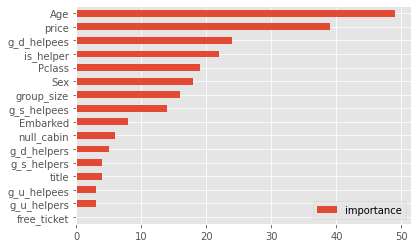

In [ ]:
importance = pd.DataFrame(models[0].feature_importance(), index=train_X.columns, columns=['importance']).sort_values(by='importance', ascending=True)
importance.plot.barh()

In [ ]:
preds = []
for model in models:
  pred = model.predict(test_X)
  preds.append(pred)

preds_array = np.array(preds)
preds_mean = np.mean(preds_array, axis=0)
preds_int = (preds_mean > 0.5).astype(int)
preds_int

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

# 7. Submission

In [ ]:
submission = pd.read_csv('gender_submission.csv')
submission['Survived'] = preds_int
submission.to_csv('titanic_submit01.csv', index=False)
!kaggle competitions submit titanic -f titanic_submit01.csv -m 'utilize Ticket'
!head titanic_submit01.csv

100% 2.77k/2.77k [00:00<00:00, 12.8kB/s]
Successfully submitted to Titanic - Machine Learning from DisasterPassengerId,Survived
892,0
893,1
894,0
895,0
896,1
897,0
898,1
899,0
900,1


2021/4/11 4/10土曜日の状況の再現を試みたら、0.79425に戻った。やったね。